# I. Introduction

- For environment selection, I have decided to go with Jupyter Notebook which already exists in PyCharm,
because I thought I could take notes and fill a pseudo-report while I am coding.
- For machine learning models, I have decided to use scikit-learn library, which I have found much easier to use compared
to other popular libraries like TensorFlow and PyTorch.

In [2]:
%watermark -v -m -p sklearn,pandas,numpy,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

sklearn   : 1.1.1
pandas    : 1.4.2
numpy     : 1.22.4
matplotlib: 3.5.2
seaborn   : 0.11.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit



- All the functions and classes that I have personally written are inside the <code>models</code> and 
<code>utility</code> packages.

# II. Imports and Configurations

In [3]:
from models import *
from utility import *
from IPython.display import Image
import seaborn as sns
import numpy as np

pd.set_option("display.precision", 2)
np.set_printoptions(precision=2, suppress=True)

raw_dataset = pd.read_csv('dataset.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy()
predict_set = dataset.tail(20)
dataset = dataset.drop(predict_set.index)

# III. Insights

- Before applying any machine learning algorithms, I wanted to see how each of the given predictors relate to each other.
- To achieve this, I have found the pairplot() function from seaborn library, which takes the columns as parameters
and plots each one of them with another.

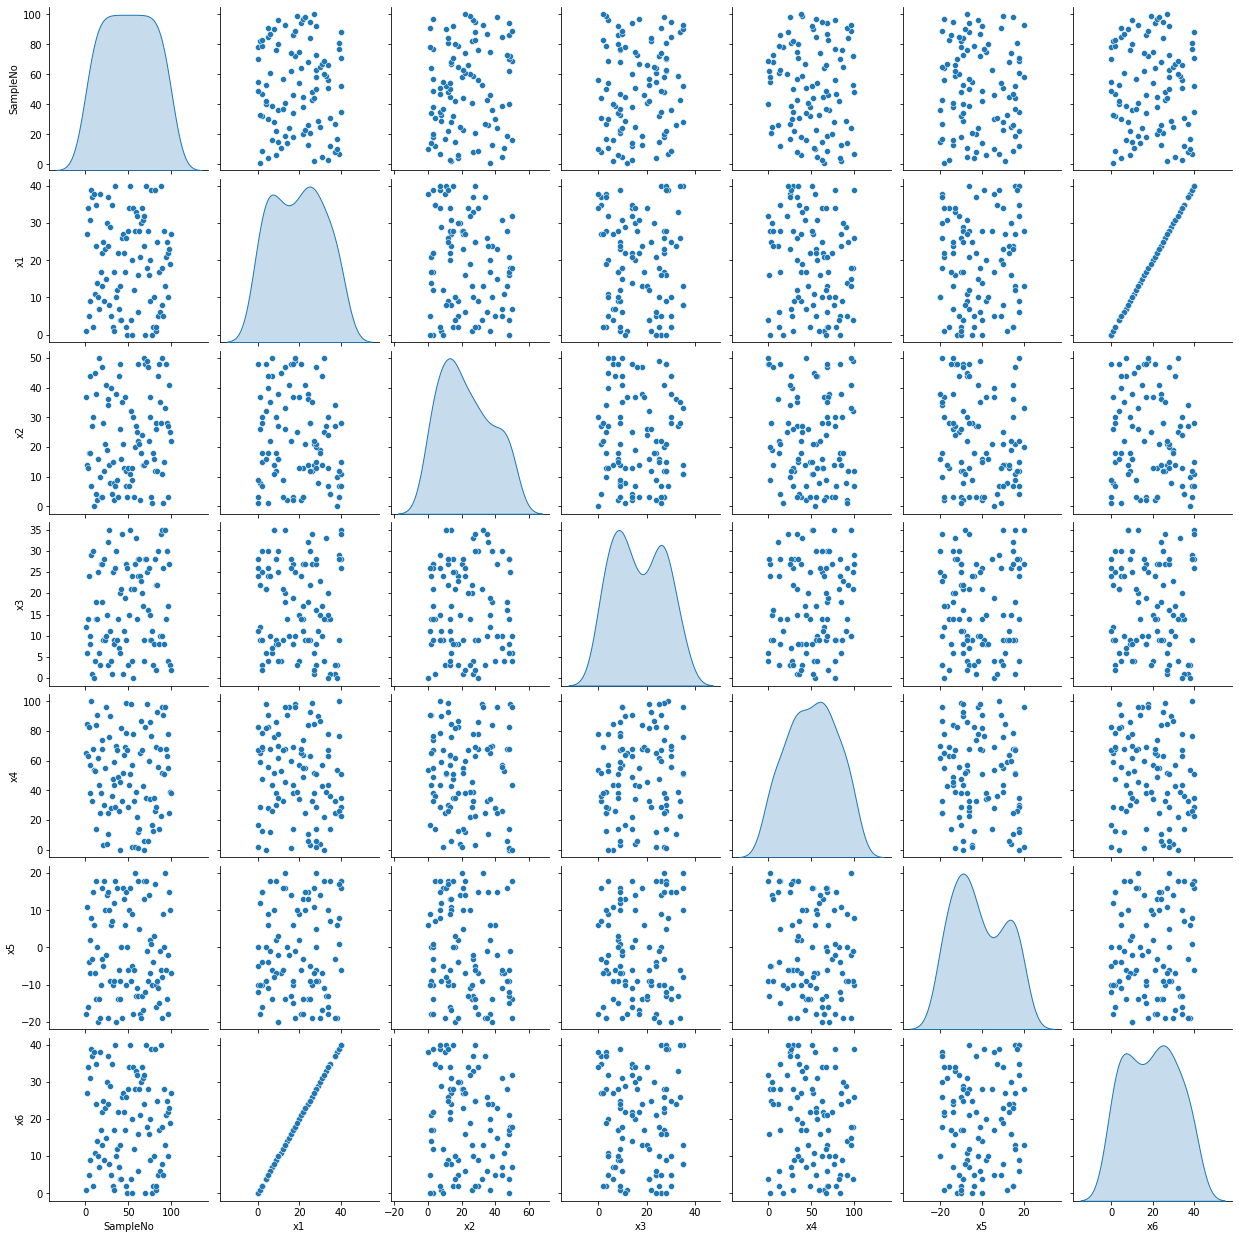

In [4]:
predictors = ['SampleNo', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']
sns.pairplot(dataset[predictors], diag_kind='kde')

- From looking at those results, it is clear that x1 and x6 values are exactly the same. So, I have decided to drop x6
predictor since we do not need the same values twice.
- I have previously included SampleNo as a predictor (even it doesn't make sense) to see if it makes the algorithms
perform better, which it obviously didn't. So, I am also dropping the SampleNo from the dataset and the predictors list.

In [5]:
dataset = dataset.drop('x6', axis=1)
predictors.remove('x6')

dataset = dataset.drop('SampleNo', axis=1)
predictors.remove('SampleNo')

features, labels = dataset[predictors], dataset['Y']

predictor_combinations = get_combinations(inputs=predictors, min_element=1)
all_results_table = ModelResultsTable()

model_grid = [{'model': single_linear_regression,
               'predictors': [[p] for p in predictors],  # 'predictors': predictors,
               'arg': [0]},
              {'model': multiple_linear_regression,
               'predictors': get_combinations(inputs=predictors),
               'arg': [0]},
              {'model': polynomial_regression,
               'predictors': predictor_combinations,
               'arg': range(2, 5)},
              {'model': k_nearest_regression,
               'predictors': predictor_combinations, 'arg': range(1, 10)},
              {'model': decision_tree_regression,
               'predictors': predictor_combinations, 'arg': range(1, 6)}]

table_heuristics = dataset.describe().transpose()[['min', 'max', 'mean', 'std']]
display(table_heuristics)

,min,max,mean,std
x1,0.0,40.0,19.29,12.32
x2,0.0,50.0,22.53,15.02
x3,0.0,35.0,16.68,10.38
x4,0.0,100.0,50.60,28.24
x5,-20.0,20.0,-1.44,12.27
Y,-42.0,12402.0,1746.82,2696.08


- Then, I wanted to see how each of the remaining predictors relate to Y separately.

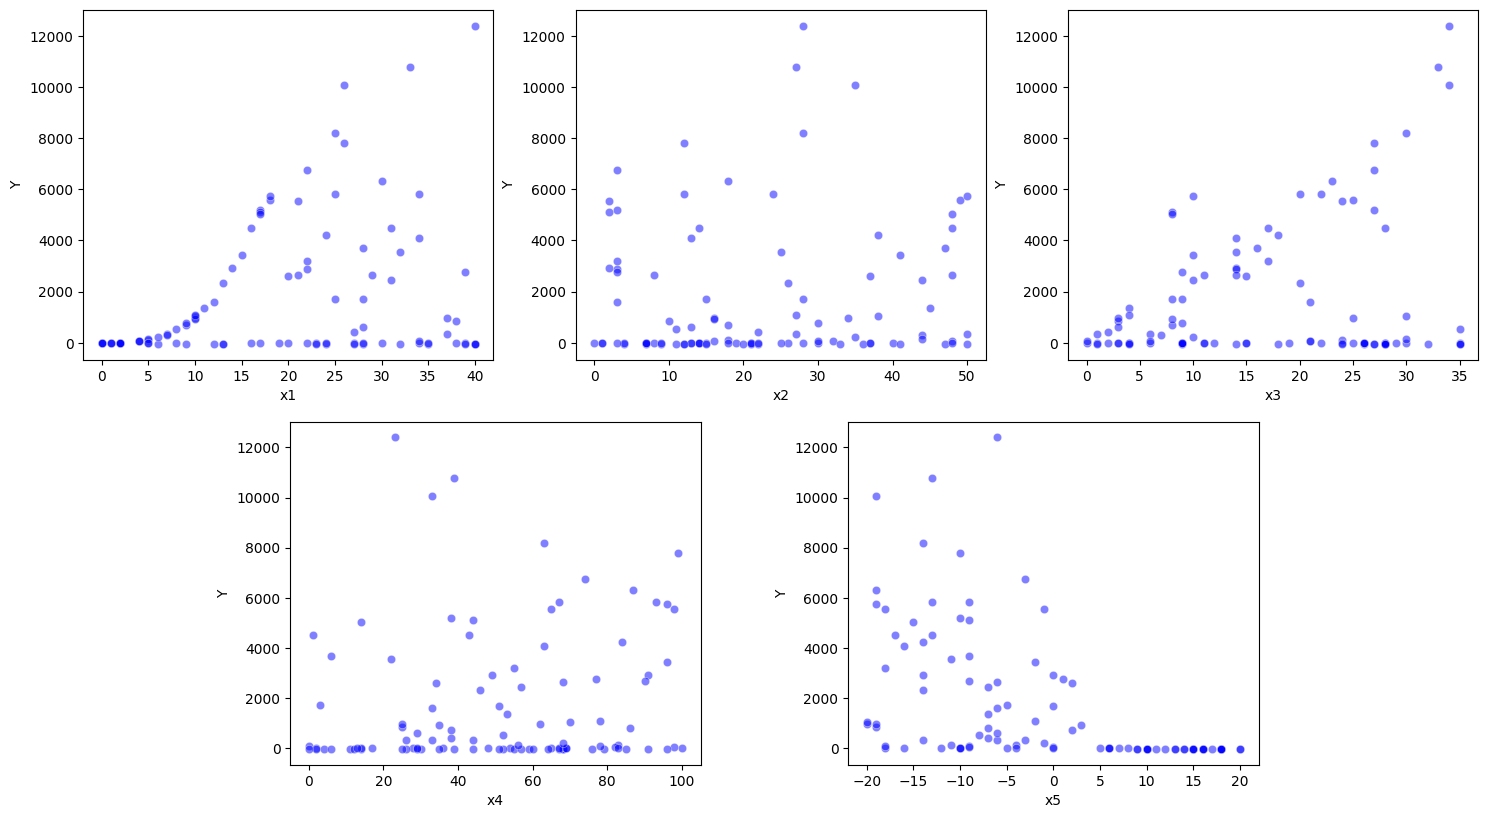

In [6]:
subplot_for_five(dataset, predictors=predictors)

- From here, I can see that when data points have x5 values greater than 5, their Y values are unmistakably lower than
when they don't.
- Because of this, I assumed that a threshold value of x5 = 5 should separate those plots.

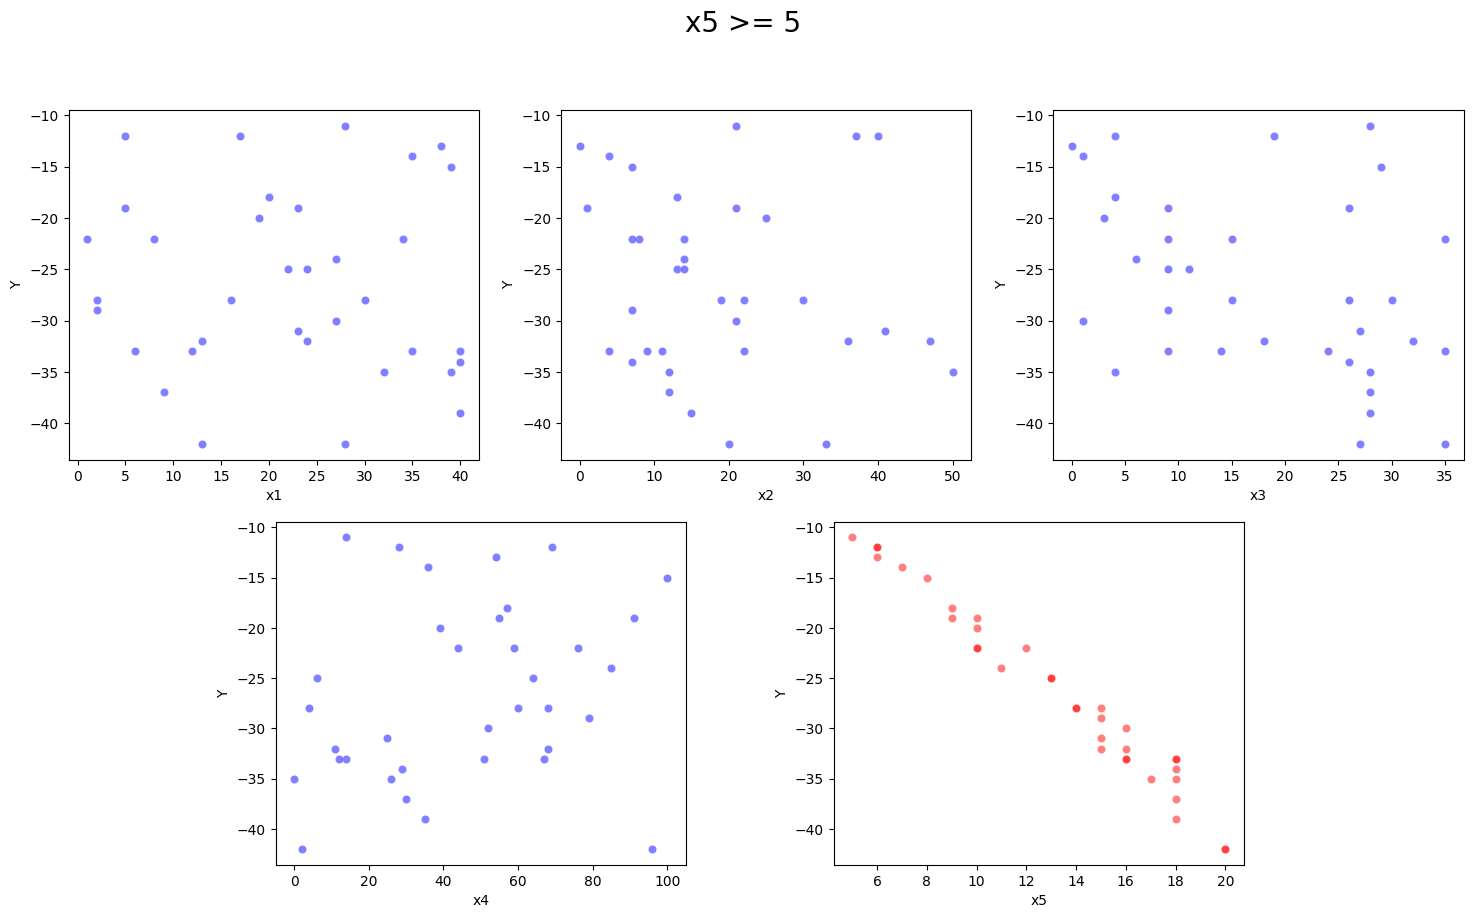

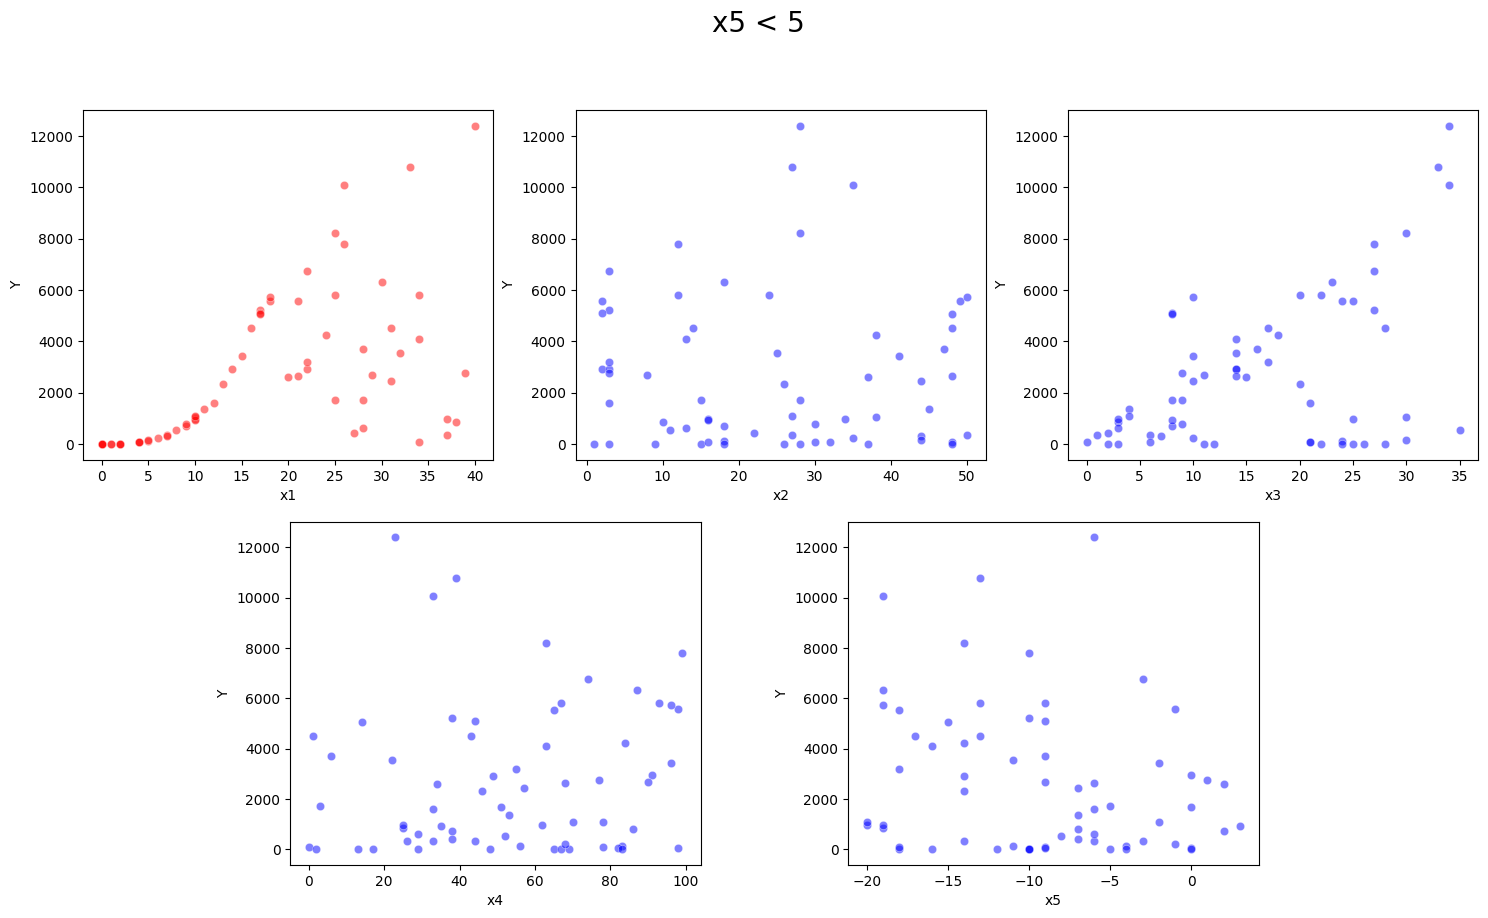

In [7]:
x5_lt, x5_gt = split_by_threshold(dataset, 'x5', threshold=5)
subplot_for_five(predictors=predictors, data=x5_gt, title='x5 >= 5', highlight=4)
subplot_for_five(predictors=predictors, data=x5_lt, title='x5 < 5', highlight=0)

- Those plots gave me a clear indication that when x5 >= 5, we could apply a linear (or 2<sup>nd</sup> degree polynomial)
regression line to x5, and it would fit almost perfectly.

- What is more interesting is that when x5 does not meet this condition, x1 values that are less than 20 suggest a
3<sup>rd</sup> degree polynomial to be fit. So, now I split the remaining data points to also meet this condition.

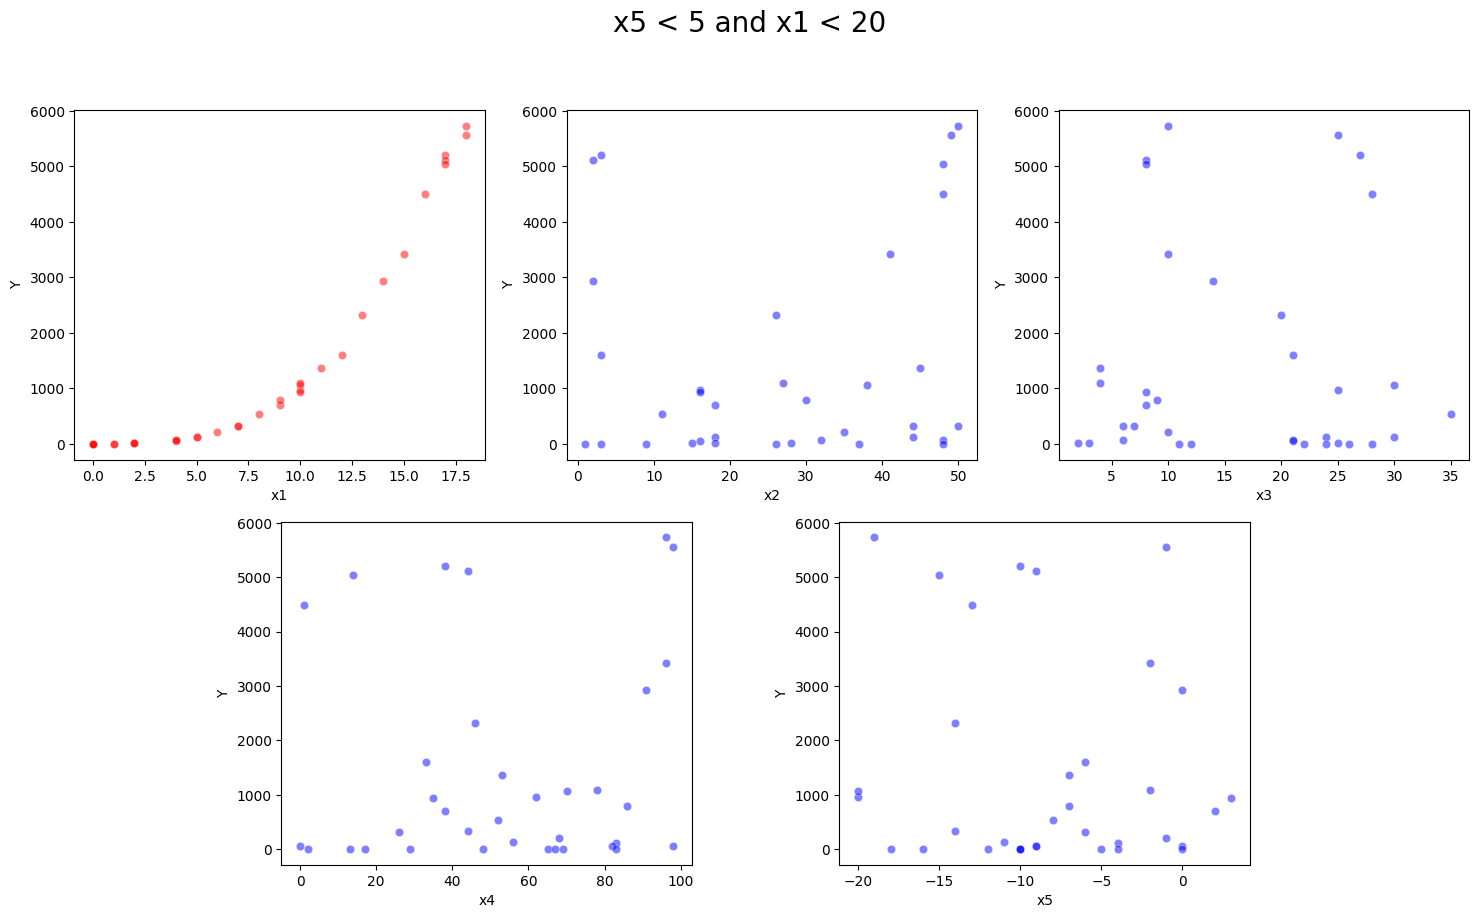

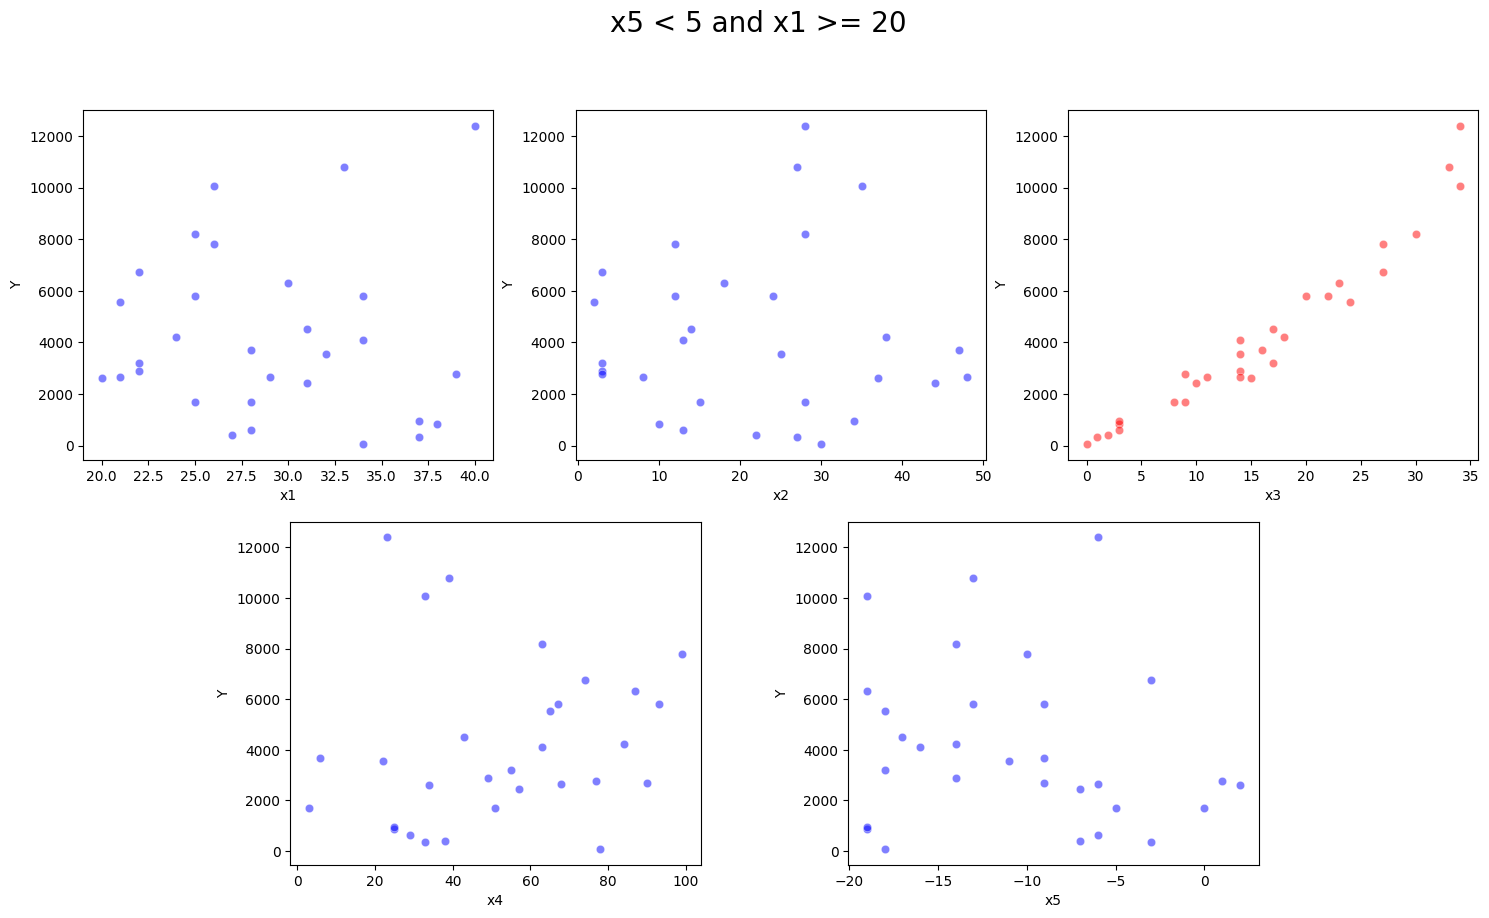

In [8]:
x1_lt, x1_gt = split_by_threshold(x5_lt, 'x1', threshold=20)
subplot_for_five(predictors=predictors, data=x1_lt, title='x5 < 5 and x1 < 20', highlight=0)
subplot_for_five(predictors=predictors, data=x1_gt, title='x5 < 5 and x1 >= 20', highlight=2)

- As final condition sufficiently fits the points x1 < 20 and x1 >= 20, all outcomes look like the following:

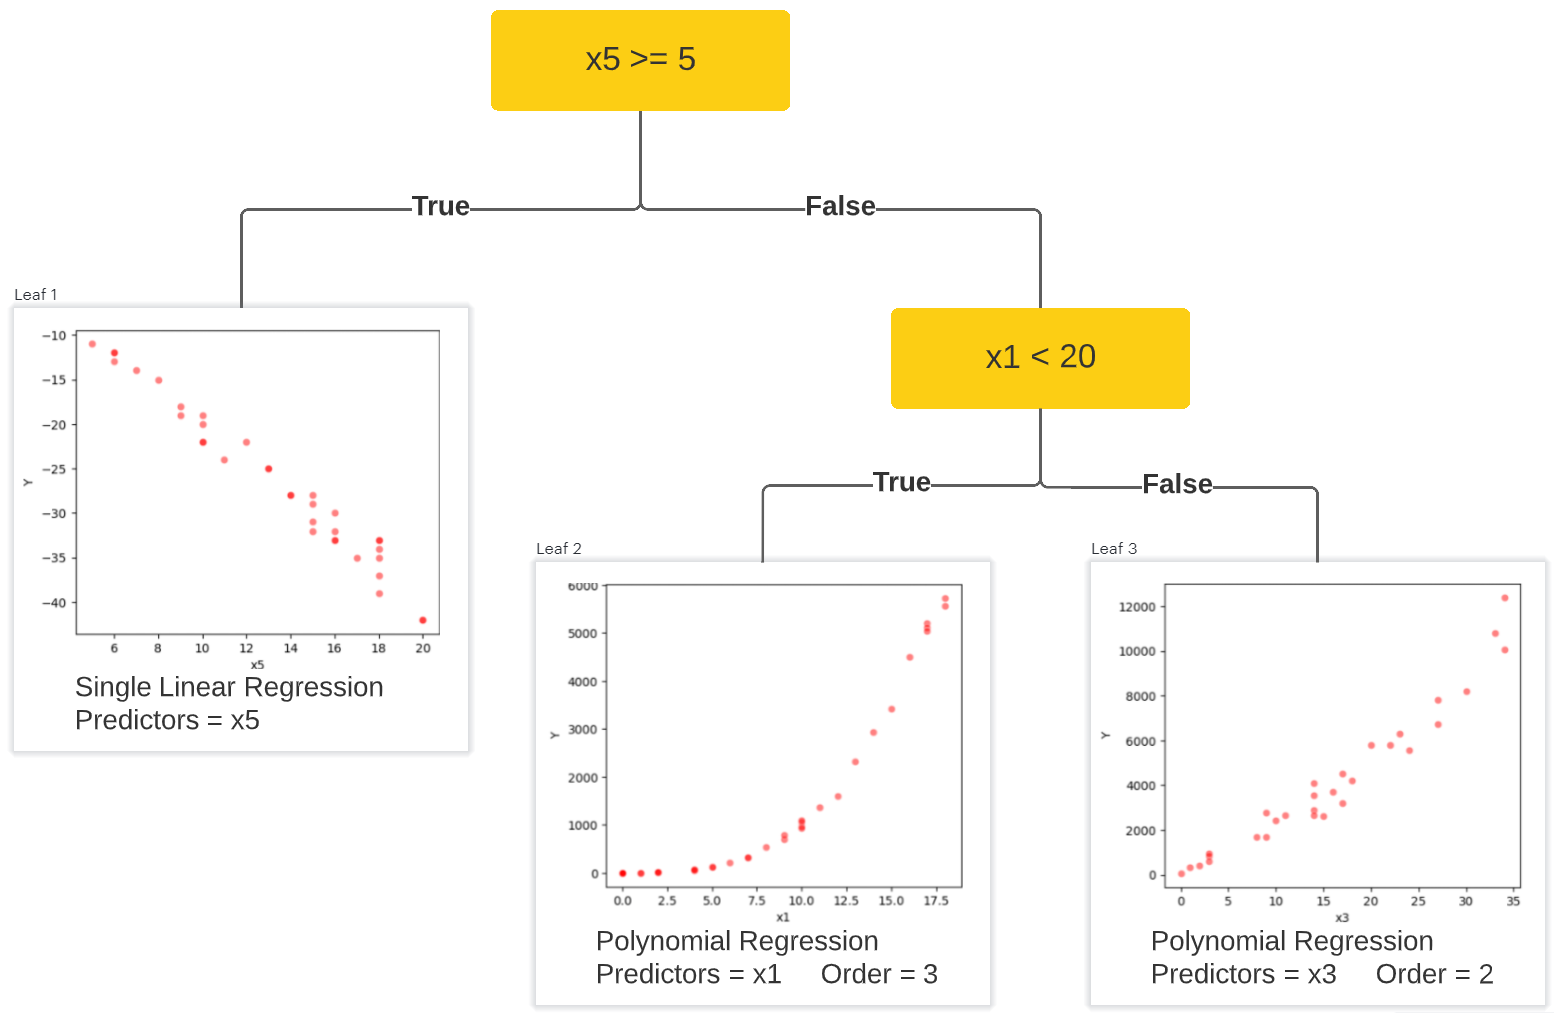

In [9]:
Image(filename='simple_decision_tree.png')

- What is written under the plots are what I have considered as "suitable enough" model-parameter selections.
To make the actual best model-predictor-argument selection, I wanted to cross-validate every possible combination.

In [10]:
model_tree = ModelTree(source_set=dataset, inputs=predictors, model_grid=model_grid)
model_tree.fit_conditions(['x5>5', 'x1<20', 'x1>20'])

### Models for the first condition: x5 >= 5,

- All the models are well-fit with very low mean absolute error values for the first condition.
- To keep the complexity low, I stick to my initial choice of Linear Regression with x5 as its input predictor.

In [11]:
first_model_table = model_tree.conditional_fits_table[0].error_table(model='all', top=3, return_table=True)
first_model = first_model_table.iloc[7]

,error,model,predictors,arg
0,1.20,multiple_linear_regression,"[x3, x5]",
1,1.20,multiple_linear_regression,"[x1, x3, x5]",
2,1.21,multiple_linear_regression,"[x2, x3, x5]",
3,1.24,polynomial_regression,"[x2, x3, x5]",order=2
4,1.29,polynomial_regression,[x5],order=4
5,1.30,polynomial_regression,"[x3, x5]",order=2
6,1.35,decision_tree_regression,[x5],max_depth=4
7,1.36,single_linear_regression,[x5],
8,1.36,decision_tree_regression,[x5],max_depth=5
9,1.44,decision_tree_regression,"[x2, x5]",max_depth=5


### Models for the second condition: x5 < 5 and x1 < 20,

- For the second condition, Polynomial and K-Nearest Regression models are outperforming the others.
- Between these two choices, I have chosen Polynomial Regression models by considering the shape of the plot.
- To keep complexity low again, I choose 3<sup>rd</sup> degree argument over 4<sup>th</sup> degree argument, which was
also my initial choice.

In [12]:
second_model_table = model_tree.conditional_fits_table[1].error_table(model='all', top=3, return_table=True)
second_model = second_model_table.iloc[2]

,error,model,predictors,arg
0,69.32,polynomial_regression,[x1],order=4
1,75.59,k_nearest_regression,[x1],k=4
2,76.82,polynomial_regression,[x1],order=3
3,80.95,polynomial_regression,"[x1, x3]",order=4
4,96.44,k_nearest_regression,[x1],k=2
5,109.02,k_nearest_regression,[x1],k=3
6,140.69,decision_tree_regression,[x1],max_depth=5
7,158.99,decision_tree_regression,"[x1, x4]",max_depth=4
8,159.07,decision_tree_regression,[x1],max_depth=4
9,786.96,multiple_linear_regression,"[x1, x4]",


### Models for the second condition: x5 < 5 and x1 >= 20,

- For the last condition, Polynomial Regression models outperform any other models that I have tested.
- It looks like my initial choice of parameters couldn't even make up to the top 3 performers for Polynomial Regression
models. It makes sense since the data points on the plot are dense and sparse time to time, so Y should be dependent on
some other predictor or predictors in addition to x3.
- Even though the Polynomial model with <span style='color:orange'>predictors=[x1, x3, x4]</span> gives the best result,
I have decided to only select the model with <span style='color:orange'>predictors=[x1, x3]</span> to reduce dimensionality.

In [13]:
third_model_table = model_tree.conditional_fits_table[2].error_table(model='all', top=3, return_table=True)
third_model = third_model_table.iloc[1]

,error,model,predictors,arg
0,136.94,polynomial_regression,"[x1, x3, x4]",order=2
1,150.08,polynomial_regression,"[x1, x3]",order=2
2,155.23,polynomial_regression,"[x1, x3]",order=3
3,368.81,multiple_linear_regression,"[x1, x3]",
4,372.03,multiple_linear_regression,"[x1, x3, x4]",
5,377.48,multiple_linear_regression,"[x1, x2, x3]",
6,583.48,k_nearest_regression,[x3],k=2
7,628.92,k_nearest_regression,[x3],k=3
8,641.65,decision_tree_regression,"[x1, x3, x4]",max_depth=5
9,643.69,decision_tree_regression,"[x1, x3, x4]",max_depth=4


- After selecting the desired models to be fit to conditionally split datasets, it is time to apply them on model tree's
leaf nodes.

In [14]:
selected_models = [first_model, second_model, third_model]
model_tree.select_leaf_models(model_results=selected_models)

- Now we can finally visualize and evaluate the model as a whole.

Total CV Score (MAE) = 228.26


,Model,Predictors,Args,Error
x5>=5,single_linear_regression,[x5],,1.36
x5<5 && x1<20,polynomial_regression,[x1],order=3,76.82
x5<5 && x1>=20,polynomial_regression,"[x1, x3]",order=2,150.08


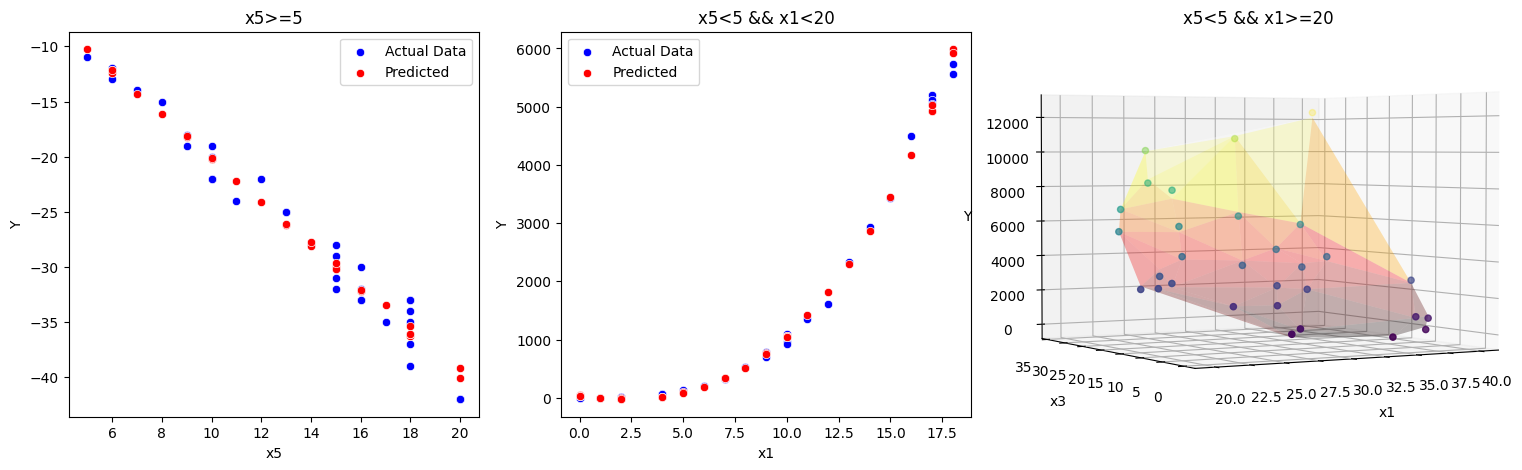

In [15]:
titles = ['x5>=5', 'x5<5 && x1<20', 'x5<5 && x1>=20']
model_tree.plot_models(plot_titles=titles, angle_3d=240, cmap='hot')

model_tree_result = model_tree.return_model_result()
all_results_table.add_model([model_tree_result])

- The results for a half-baked model that I have been working on for a couple of weeks surely doesn't seem so bad.
- To make sure it outperforms the model estimators that sklearn provides, I will keep going and cross-validate it with
every model-predictor-argument combination given to the sklearn regression functions.

# IV. Scikit-learn Regression Models

## IV.I. Single Linear Regression

- I didn't really have much hope for those, but there was nothing that I can lose.

,,,,,
predictors,x5,x1,x3,x4,x2
error,1617.44,1926.81,2058.32,2086.5,2119.9


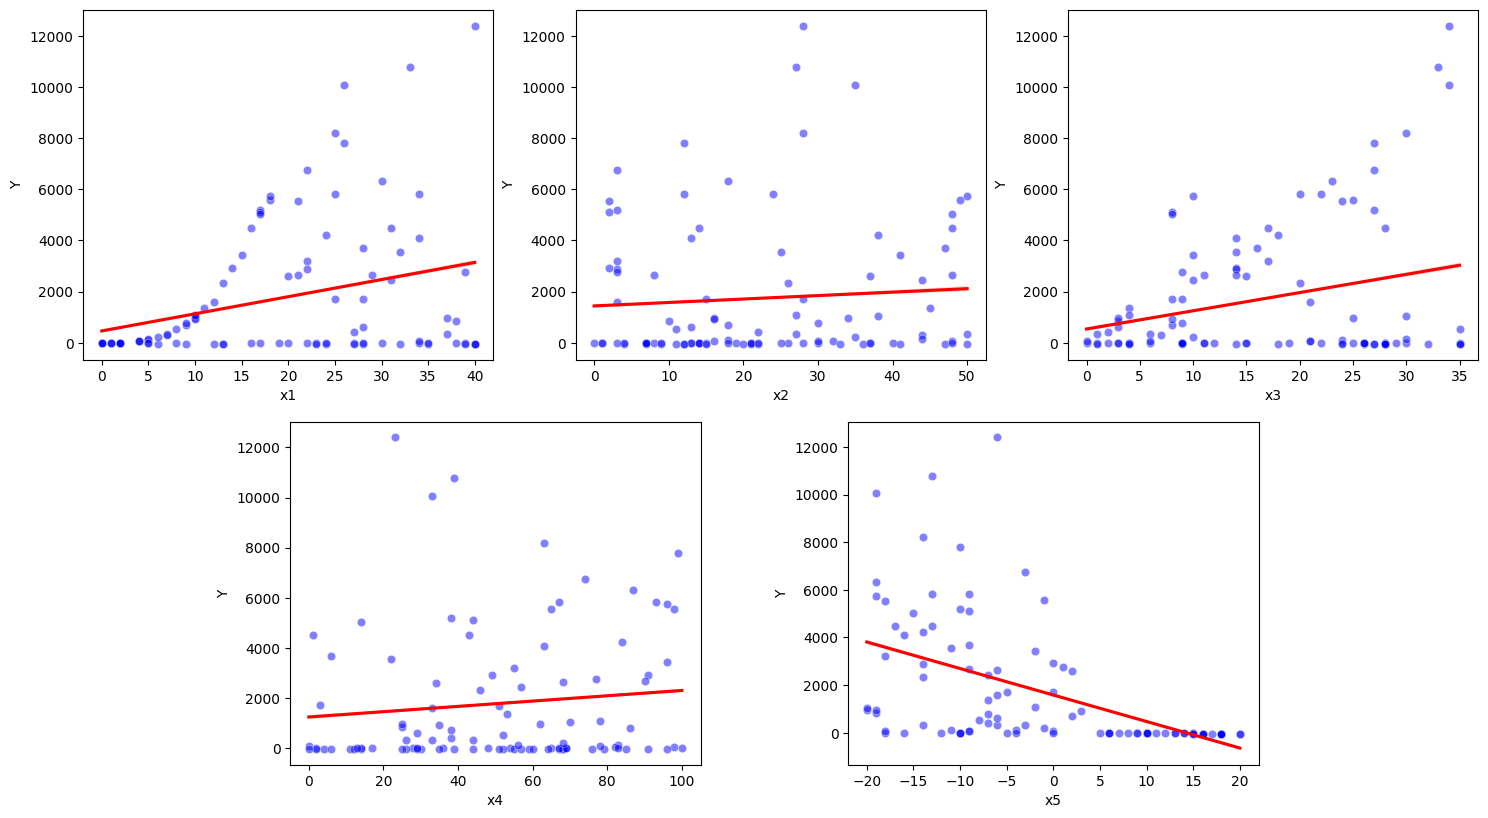

In [16]:
lin_reg_args = predictors
lin_reg_results = [ModelResult(single_linear_regression(x=features, y=labels, inputs=p))
                   for p in lin_reg_args]

subplot_for_five(dataset, predictors=predictors, reg_plot=lin_reg_results)

all_results_table.add_model(lin_reg_results)
all_results_table.error_table(model='single_linear_regression', transpose=True)

## IV.II. Multiple Linear Regression

- Interestingly, increasing dimensionality didn't really help the model score at all. So, linearity is definitely out
of the question.
- The best (<span style='color:orange;'>predictors=[x1, x2, x3, x4, x5]</span>) and the 4<sup>th</sup> best performing
model (<span style='color:orange;'>predictors=[x1, x3, x5]</span>) almost had the same model scores, so choosing the
model with the least number of predictors were more reasonable.

In [17]:
multi_lin_reg_args = get_combinations(inputs=predictors)
multi_lin_reg_results = [ModelResult(multiple_linear_regression(x=features, y=labels, inputs=ps))
                         for ps in multi_lin_reg_args]

all_results_table.add_model(multi_lin_reg_results)
all_results_table.error_table(model='multiple_linear_regression', transpose=True)
all_results_table.update_selected_model('multiple_linear_regression', index=3)

,,,,,,,,,,,...,,,,,,,,,,
predictors,"[x1, x2, x3, x4, x5]","[x1, x2, x3, x5]","[x1, x3, x4, x5]","[x1, x3, x5]","[x1, x4, x5]","[x1, x2, x4, x5]","[x1, x5]","[x1, x2, x5]","[x3, x5]","[x3, x4, x5]",...,"[x1, x2, x3, x4]","[x1, x2, x4]","[x1, x2, x3]","[x1, x3, x4]","[x1, x3]","[x1, x2]","[x3, x4]","[x2, x3, x4]","[x2, x3]","[x2, x4]"
error,1511.92,1517.51,1523.63,1524.51,1567.47,1576.54,1582.77,1589.46,1618.96,1619.28,...,1911.57,1916.16,1918.69,1927.76,1930.42,1931.28,2050.98,2051.07,2056.87,2095.52


## IV.III. Polynomial Regression

- Now, this is some improvement over linear models.
- Selecting 3<sup>rd</sup> degree polynomial with <span style='color:orange;'>predictors=[x1, x3, x5]</span> almost halved the mean absolute error, but
it is still far from my model tree.

In [18]:
poly_reg_args = range(2, 6)
poly_reg_results = [ModelResult(polynomial_regression(features, labels, arg=order, inputs=p))
                    for order in poly_reg_args
                    for p in predictor_combinations]

all_results_table.add_model(poly_reg_results)
all_results_table.error_table(model='polynomial_regression', transpose=True)

,order=3,order=4,order=3,order=2,order=2,order=3,order=2,order=2,order=5,order=5,...,order=5,order=4,order=4,order=5,order=4,order=5,order=5,order=5,order=5,order=5
predictors,"[x1, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x3, x4, x5]","[x1, x2, x3, x4, x5]","[x1, x3, x4, x5]","[x1, x5]","[x1, x3, x5]",...,"[x2, x3, x4]","[x2, x3, x4, x5]","[x1, x2, x4, x5]","[x1, x2, x3, x4, x5]","[x1, x2, x3, x4, x5]","[x2, x3, x4, x5]","[x1, x2, x3, x4]","[x1, x2, x3, x5]","[x1, x3, x4, x5]","[x1, x2, x4, x5]"
error,822.37,898.67,1005.21,1045.07,1054.58,1070.23,1090.24,1107.71,1145.6,1236.91,...,6437.72,6535.91,7716.91,12199.52,12615.04,15486.0,16760.5,17793.74,24364.87,28087.64


## IV.IV. K-Nearest-Neighbors Regression

- Again, another decent improvement over the previous models.
- Models with <span style="color:orange;">predictors=[x1, x3, x5]</span> give the best cross-validation scores, as they previously did.
- Although <span style="color:red">k=1</span> is the best performing model, choosing at least
<span style="color:red">k=3</span> would be better in terms of lowering the complexity.

In [19]:
knn_reg_args = range(1, 10)
knn_reg_results = [ModelResult(k_nearest_regression(features, labels, arg=k, inputs=p))
                   for k in knn_reg_args
                   for p in predictor_combinations]

all_results_table.add_model(knn_reg_results)
all_results_table.error_table(model='k_nearest_regression', transpose=True)
all_results_table.update_selected_model('k_nearest_regression', index=2)

,k=1,k=2,k=3,k=5,k=4,k=1,k=6,k=7,k=2,k=8,...,k=1,k=2,k=9,k=7,k=8,k=3,k=1,k=2,k=1,k=1
predictors,"[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x4, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x4, x5]","[x1, x3, x5]",...,"[x2, x3]","[x2, x3]","[x2, x4]","[x2, x4]","[x2, x4]","[x2, x3]","[x3, x4]",[x4],[x2],[x4]
error,516.63,609.54,636.38,657.28,681.07,713.19,720.99,766.48,803.44,803.7,...,2217.76,2227.85,2230.58,2232.4,2239.43,2262.22,2266.68,2297.36,2319.67,2406.36


## IV.V.I. Decision Tree Regression

- As max depth of a regression tree increases, its cross-validation  error decreases, which wasn't a surprise since
the alpha values for the increasing number of nodes were not taken into account.
- Instead of performing a hyper-parameter tuning with thousands of parameters for each,
I simply decided to choose the model (<span style='color:orange;'>predictors=[x1, x3, x5]</span>, <span style='color:red'>max_depth=5</span>), 
which relatively had lower complexity compared to others that have performed better. Mean absolute error wasn't affected that much
either, so it was an easy choice.
- Similar things exist for the following bootstrap aggregated tree models.

In [20]:
dec_tree_args = range(1, 10)
dec_tree_results = [ModelResult(decision_tree_regression(features, labels, arg=depth, inputs=p))
                    for depth in dec_tree_args
                    for p in predictor_combinations]

all_results_table.add_model(dec_tree_results)
all_results_table.error_table(model='decision_tree_regression', transpose=True)
all_results_table.update_selected_model('decision_tree_regression', index=5)

,max_depth=8,max_depth=7,max_depth=7,max_depth=8,max_depth=9,max_depth=5,max_depth=9,max_depth=6,max_depth=5,max_depth=6,...,max_depth=7,max_depth=5,max_depth=5,max_depth=8,max_depth=9,max_depth=6,max_depth=7,max_depth=9,max_depth=8,max_depth=6
predictors,"[x1, x2, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x4, x5]",...,"[x2, x4]","[x2, x4]",[x4],"[x2, x4]","[x2, x4]",[x4],[x4],[x4],[x4],"[x2, x4]"
error,449.27,454.22,454.23,455.35,459.41,460.36,474.53,478.95,509.54,525.37,...,2470.91,2483.82,2496.53,2538.8,2554.85,2563.02,2616.37,2654.83,2669.67,2720.44


## IV.V.II. Decision Tree Regression + Bagging

In [21]:
bag_tree_args = dec_tree_args
bag_tree_results = [ModelResult(bagging_tree_regression(features, labels, arg=depth, inputs=p))
                    for depth in bag_tree_args
                    for p in predictor_combinations]

all_results_table.add_model(bag_tree_results)
all_results_table.error_table(model='bagging_tree_regression', transpose=True)
all_results_table.update_selected_model('bagging_tree_regression', index=5)

,max_depth=8,max_depth=9,max_depth=7,max_depth=6,max_depth=9,max_depth=5,max_depth=6,max_depth=5,max_depth=8,max_depth=7,...,max_depth=8,max_depth=8,max_depth=9,max_depth=4,max_depth=9,max_depth=5,max_depth=6,max_depth=7,max_depth=8,max_depth=9
predictors,"[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x5]",...,"[x2, x4]",[x2],[x2],[x4],"[x2, x4]",[x4],[x4],[x4],[x4],[x4]
error,557.38,558.42,567.32,572.15,598.82,602.6,611.53,621.9,624.12,627.96,...,2153.19,2160.53,2169.62,2177.8,2180.24,2210.84,2255.33,2284.3,2310.26,2326.41


## IV.V.III. Decision Tree Regression + Boosting

In [22]:
boost_tree_args = dec_tree_args
boost_tree_results = [ModelResult(boosting_tree_regression(features, labels, arg=depth, inputs=p))
                      for depth in boost_tree_args
                      for p in predictor_combinations]

all_results_table.add_model(boost_tree_results)
all_results_table.error_table(model='boosting_tree_regression', transpose=True)
all_results_table.update_selected_model('boosting_tree_regression', index=6)

,max_depth=8,max_depth=8,max_depth=9,max_depth=7,max_depth=9,max_depth=7,max_depth=5,max_depth=6,max_depth=9,max_depth=9,...,max_depth=5,max_depth=7,max_depth=6,max_depth=7,max_depth=8,max_depth=9,max_depth=9,max_depth=8,max_depth=5,max_depth=6
predictors,"[x1, x2, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x4, x5]","[x1, x2, x3, x4, x5]",...,[x4],"[x2, x4]",[x4],[x4],[x4],"[x2, x4]",[x4],"[x2, x4]","[x2, x4]","[x2, x4]"
error,454.86,455.91,457.95,469.16,474.42,477.73,490.13,502.67,540.37,544.07,...,2489.58,2506.47,2521.36,2533.8,2567.51,2577.47,2580.1,2580.47,2623.4,2755.17


## IV.VI. Random Forest Regression

In [23]:
rf_args = range(1, 10)
rand_forest_results = [ModelResult(random_forest_regression(features, labels, arg=depth, inputs=p))
                       for depth in rf_args
                       for p in predictor_combinations]

all_results_table.add_model(rand_forest_results)
all_results_table.error_table(model='random_forest_regression', transpose=True)
all_results_table.update_selected_model('random_forest_regression', index=4)

,max_depth=7,max_depth=9,max_depth=8,max_depth=6,max_depth=5,max_depth=8,max_depth=9,max_depth=7,max_depth=6,max_depth=5,...,max_depth=7,max_depth=9,max_depth=8,max_depth=9,max_depth=4,max_depth=5,max_depth=6,max_depth=7,max_depth=8,max_depth=9
predictors,"[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x5]",...,[x2],"[x2, x4]",[x2],[x2],[x4],[x4],[x4],[x4],[x4],[x4]
error,561.88,561.94,583.68,584.97,599.65,614.25,615.9,619.78,629.99,636.12,...,2143.67,2151.47,2160.53,2169.62,2177.8,2210.84,2255.33,2284.3,2310.26,2326.41


# V. Conclusion
- Displaying the model results by their best predictor-argument selection shows that the model that produces less
cross-validation is actually my model tree.
- Either this model works like wonders or I have done something terribly wrong. In either case, I am too far gone to
turn back, and I want to take the risk of selecting my own model.

In [24]:
all_results_table.error_table(model='best')
best_model = list(all_results_table.model_results_with_best_params.values())[0].estimator

,args,predictors,error
model_tree_regression(?),"[, order=3, order=2]","[[x5], [x1], [x1, x3]]",228.26
decision_tree_regression,max_depth=5,"[x1, x3, x5]",460.36
boosting_tree_regression,max_depth=5,"[x1, x3, x5]",490.13
random_forest_regression,max_depth=5,"[x1, x3, x5]",599.65
bagging_tree_regression,max_depth=5,"[x1, x3, x5]",602.60
k_nearest_regression,k=3,"[x1, x3, x5]",636.38
polynomial_regression,order=3,"[x1, x3, x5]",822.37
multiple_linear_regression,,"[x1, x3, x5]",1524.51
single_linear_regression,,x5,1617.44


- Which leads us to final part of the report, which is the unlabeled data predictions.
- There are not many things to discuss here, but I want to talk about the project in general as my final words.
- This project was fairly challenging (at least for me) in terms of trying to come up with something meaningful without
knowing anything about its context. This includes obscure naming of predictors and having no sense of outliers.
- And worst of all was trying to understand the abstract API that scikit provides. There were many cases when I couldn't
get any answer from looking at documentations all day, and then gave up and resort to my classic trial and error method.
- But overall, I think that was a great puzzle to solve, and I really enjoyed working on this project.

In [25]:
final_predictions = best_model.predict(x=predict_set)
show_predictions(predictions=final_predictions, filepath='predictions.csv')

SampleNo,Predictions
101,-10
102,-26
103,192
104,1403
105,-40
106,-3
107,-19
108,139
109,9855
110,-36
